<a href="https://colab.research.google.com/github/yardsale8/DSCI_326_module_4_lazy_operations/blob/main/4_0_2_lazy_and_eager_argument_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import rpy2
%load_ext rpy2.ipython

# Lazy and Eager Argument Evaluation

In this lecture, we will highlight one of the big differences between Python and R: How function arguments are evaluated.

## Two types of function evaluation.

Depending on language, evaluation of functions either

1. **Applicative Order**/**Eager Evaluation**, where all arguments are evaluated before the body of the function, or
2. **Normal Order**/**LAzy Evaluation**, where function arguments are only evaluated as needed.

### Python uses applicative order.

1. All arguments are evaluated into values, then
2. The body of the function is evaluated using these values.

### R uses normal order.

1. All arguments are passed to the function as unevaluated expressions, and
2. These expressions are only evaluated as needed.

## Example 1 - Assignment expressions

To illustrate, we first use a trackable side-effect, namely the assignment expression.  This will allow us to see if/when the arguments are evaluated by inspecting the resulting value of the assigned output variable.

### R doesn't process both assignment expressions

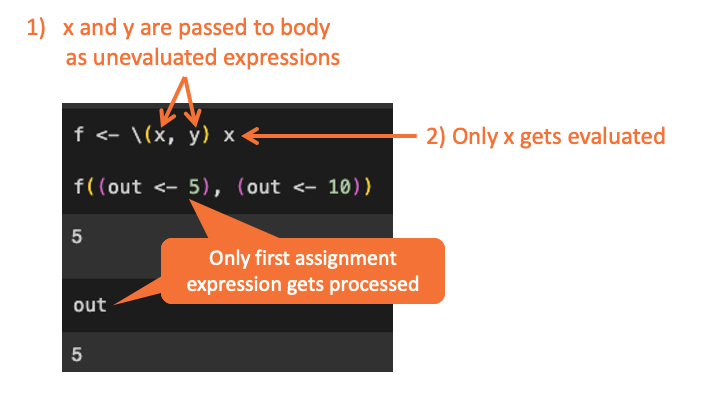
In `R`, only the first assignment statement is evaluated, since only `x` is used in the body of the function.  Consequently, `out` gets the value of the first assignment.

In [5]:
%%R
f <- \(x, y) x

f((out <- 5), (out <- 10))

[1] 5


In [6]:
%R out

array([5.])

### Python processes both assignment statements first

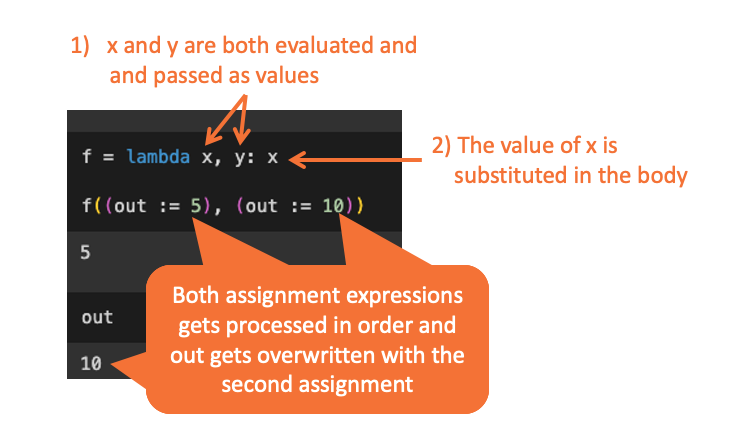
On the other hand, both assignment statements are evaluated in Python first, resulting in `out` getting the value of the second assignment.

In [7]:
f = lambda x, y: x

f((out := 5), (out := 10))

5

In [8]:
out

10

### Example 2 - Divide by zero

In R, we never evaluate `y`, since it isn't referenced in the body, so we never see the error for dividing by zero.

In [22]:
%%R

f(5, 1/0) # Second expression doesn't get evaluated --> no error

[1] 5


But in Python, both arguments are evaluated and we do raise an exception for dividing by zero.

In [12]:
f(5, 1/0) # Both arguments evaluated first --> exception is thrown

ZeroDivisionError: division by zero

## Consequences of this difference

### Consequence 1 - We can make our own conditionals in R but not Python

#### Non-passing branches don't evaluate!

An important property of a conditional is that only the passing branch gets evaluated.  We can see this in both Python and R `if` statements/expressions.

In [13]:
if True:
    print("Yes")
else:
    1/0 # doesn't evaluate

Yes


In [14]:
%%R
if (TRUE) {
    print("Yes")
} else {
    1/0 # Doesn't evaluate
}

[1] "Yes"


### We can write proper conditional function in R

In [15]:
%R library(dplyr)

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




'dplyr','tools','stats',...,'datasets','methods','base'


In [16]:
%%R

my_R_ifelse <- function(c, t, e) ifelse(c, t, e)

my_R_ifelse(TRUE, "Yes", 1/0) # Argument going to the else branch doesn't evaluate --> No error

[1] "Yes"


### We CANNOT write proper conditional functions in Python

Applicative order makes it impossible to write proper conditional functions in Python (without also inventing lazy expressions ... more on that next).

In [23]:
my_Python_ifelse = lambda c, t, e: t if c else e

my_Python_ifelse(True, "Yes", 1/0)  # All arguments are evaluated --> Exception is thrown

ZeroDivisionError: division by zero

### Consequence 2 - Python dataframes frameworks need lazy column expressions, but R does not.

#### In `dplyr`, we can simply references a column, even before it exists.

In [24]:
%%R

(data.frame(x = rbinom(10, 25, 0.5))
 %>% mutate(y = 2*x,        # this works because (A) normal order and (B) some dplyr magic that unpacks the data columns
            z = sqrt(y))    # Works even through y doesn't exists when the code is read.
)

    x  y        z
1  15 30 5.477226
2  10 20 4.472136
3  12 24 4.898979
4  14 28 5.291503
5  14 28 5.291503
6  16 32 5.656854
7   7 14 3.741657
8   8 16 4.000000
9  15 30 5.477226
10 12 24 4.898979


But, if we try to evaluate one of the mutate expressions outside the pipe, we get a name error.

In [19]:
%R 2*x

  object 'x' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'x' not found


But in `polars` we are required to use lazy column expressions to avoid errors, e.g., by referencing columns before they are created.

In [26]:
import polars as pl
from random import normalvariate
from numpy import sqrt

(pl.DataFrame({'x': [normalvariate(25, 5) for i in range(10)]})
 .with_columns(y = 2*x)       # Applicative order --> First try to evaluate x --> name error
 .with_columns(z = sqrt(y))
)

NameError: name 'x' is not defined

In [28]:
import polars as pl
from random import normalvariate

(pl.DataFrame({'x': [normalvariate(25, 5) for i in range(10)]})
 .with_columns(y = 2*pl.col('x'))        # Still applicative order ---> pl.col expression is lazy and is evaluted later ---> No error
 .with_columns(z = pl.col('y').sqrt())
)

x,y,z
f64,f64,f64
26.225531,52.451062,7.242311
34.333237,68.666474,8.286524
16.824203,33.648405,5.800725
20.686732,41.373465,6.432221
19.525069,39.050138,6.249011
22.988644,45.977287,6.780655
23.167208,46.334417,6.806939
28.333614,56.667229,7.527764
14.375691,28.751382,5.362032


In [21]:
2*pl.col('x')

<Expr ['[(dyn int: 2) * (col("x"))]'] at 0x7F7F09A84AC0>